Libraries

In [2]:
#using a pretrained model
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

Dataset

In [3]:
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, as_supervised=True, download= True)

In [4]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels
print(get_label_name(0))
print(get_label_name(1))

cat
dog


In [5]:
# display 2 images from the dataset
for image, label in raw_train.take(5):
  # plt.figure()
  # plt.imshow(image)
  # plt.title(get_label_name(label))
  print(label)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


Data Preprocessing

In [6]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/80) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [7]:
train = raw_train.map(format)
validation = raw_validation.map(format)
test = raw_test.map(format)

In [8]:
# for image, label in train.take(5):
#   plt.figure()
#   plt.imshow(image)
#   plt.title(get_label_name(label))

In [9]:
#shuffle and batch the images
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [10]:
for img, label in raw_train.take(1):
  print("Original shape:", img.shape)

for img, label in train.take(1):
  print("New shape:", img.shape)

Original shape: (262, 350, 3)
New shape: (160, 160, 3)


Picking up a Pretrained model

In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights = 'imagenet') 

In [20]:
#base_model.summary()

In [12]:

for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable=False
#base_model.summary() #32, 5, 5, 1280

In [14]:
#adding our classifier
global_average_layer =  tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)

In [15]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
  ])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
#training the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 21s 901ms/step - loss: 0.8101 - accuracy: 0.4516


In [45]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 609s 1s/step - loss: 0.2155 - accuracy: 0.9009 - val_loss: 0.0997 - val_accuracy: 0.9622
Epoch 2/3
582/582 [==============================] - 502s 856ms/step - loss: 0.0835 - accuracy: 0.9700 - val_loss: 0.0717 - val_accuracy: 0.9746
Epoch 3/3
582/582 [==============================] - 844s 1s/step - loss: 0.0676 - accuracy: 0.9747 - val_loss: 0.0625 - val_accuracy: 0.9785
[0.9008597731590271, 0.9699623584747314, 0.9746910333633423]


In [8]:
#model.save("E:/Vineet/work/python/machine_learning/dogs_vs_cats.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('E:/Vineet/work/python/machine_learning/dogs_vs_cats.h5')

Predictions: [[-6.7328596]]
Prediction: cat


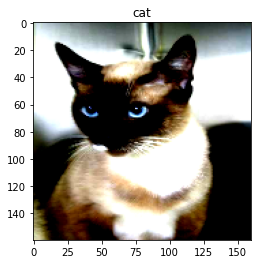

In [9]:
for img, lbl in test.take(1):
    plt.figure()
    plt.imshow(img)
    plt.title(get_label_name(lbl))
    predictions = new_model.predict(np.array([img]))
    print("Predictions:",predictions)
    print("Prediction:",get_label_name(np.argmax(predictions)))

Predictions: [[-10.5056925]]
Prediction: cat


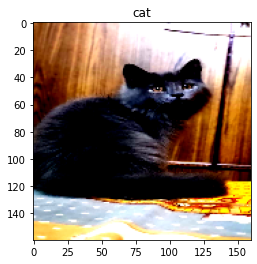

In [13]:
local_img = plt.imread('E:/Vineet/work/projects/dataset/data/CatsAndDogs/cat1.jpg')
resized_local, local_lbl = format(local_img, 0)
plt.figure()
plt.imshow(resized_local)
plt.title(get_label_name(local_lbl))
predictions = new_model.predict(np.array([resized_local]))
print("Predictions:",predictions)
print("Prediction:",get_label_name(np.argmax(predictions)))

tf.float32

Predicions: [[8.145654]]
Prediction: cat


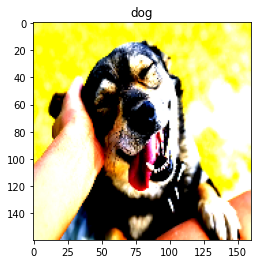

In [40]:
local_img = plt.imread('E:/Vineet/work/projects/dataset/data/CatsAndDogs/dog1.jpg')
resized_local, local_lbl = format(local_img, 1)
plt.figure()
plt.imshow(resized_local)
plt.title(get_label_name(local_lbl))
predictions = new_model.predict(np.array([resized_local]))
print("Predictions:",predictions)
print("Prediction:",get_label_name(np.argmax(predictions)))